# Diffractive metasurface inverse design with topology optimization

In this tutorial, we will use inverse design and topology optimization to design a diffractive metasurface that generates a desired intensity pattern when light is transmitted through it. We use the `autograd` feature from Tidy3D to perform gradient based optimization of a mask to minimize the difference between the measured and target intensity distribution.

With Tidy3D's `autograd` feature, we can optimize objective functions that involve arbitrary functions over measured field patterns. We define our metasurface using an arbitrary permittivity distribution as a function of (x,y) and minimize the loss function with respect to this pattern. We also include a penalty for small feature sizes.

<img src="img/adjoint_13.png" width=400 alt="Schematic of the diffractive metasurface">

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/). For another example of metalens adjoint optimization in Tidy3D, see [this example](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/).


In [7]:
import matplotlib.pyplot as plt
import numpy as np

import autograd
import autograd.numpy as anp

import tidy3d as td


## Setup

The setup is simple and similar to other examples, such as our [metalens](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/). Our structure consists of a slab of dielectric in the xy plane sitting on a substrate. A plane wave is incident from below (-z). We define the slab using a custom medium, which gives us full control of the permittivity value at each point in space.

### Set Global Parameters

In [8]:
# wavelength and source properties
wavelength = 1.0
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth

# permittivity of the mask and substrate
permittivity = 2.0

# side length on x and y
length = 20

# thickess of the metalens, enough to apply a relative phase shift of just over pi
k0 = 2 * np.pi / wavelength
delta_n = np.sqrt(permittivity) - 1
thickness = 4 / k0 / delta_n

# distances between PML and source / monitor
buffer = 1.5 * wavelength

# distances between source / monitor and the mask
dist_src = 1.5 * wavelength
dist_mnt = 6.1 * wavelength

# resolution
min_steps_per_wvl = 17

In [9]:
# total z size and the center of the slab
Lz = buffer + dist_src + thickness + dist_mnt + buffer
z_center_slab = -Lz/2 + buffer + dist_src + thickness / 2.0

In [10]:
# resolution of the design region
dl_design_region = 2 * wavelength / min_steps_per_wvl / np.sqrt(permittivity)

# number of pixel cells in the design region (in x and y)
nx = ny = int(length / dl_design_region)

### Define Simulation Components

We start with defining some "static" components, which don't depend on our design parameters.

In [11]:
# substrate of the same permittivity as the mask
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -1000),
        rmax=(+td.inf, +td.inf, z_center_slab-thickness/2)
    ),
    medium=td.Medium(permittivity=permittivity)
)

# plane wave
src = td.PlaneWave(
    center=(0, 0, -Lz/2 + buffer),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
)

# monitor we use to measure the intensity pattern above the device
mnt_out = td.FieldMonitor(
    center=(0, 0, +Lz/2 - buffer),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    colocate=False,
    name="output",
)

# monitor we use to inspect the field pattern from the side for visualization
mnt_side = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="side",
)


Next we define the mask as a function of our design parameters using topology optimization + filtering and thresholding methods.

In [24]:
from tidy3d.plugins.autograd.functions import rescale
from tidy3d.plugins.autograd.invdes import make_filter_and_project, get_kernel_size_px

radius = 0.20
beta = 50

radius = 0.120
beta = 50

filter_size = get_kernel_size_px(radius, dl_design_region)
filter_project = make_filter_and_project(filter_size)

def get_eps(params: anp.ndarray, beta: float) -> anp.ndarray: 
    """Get the permittivity values (1, permittivity) array as a funciton of the parameters (0, 1)"""
    density = filter_project(params, beta)
    eps = rescale(density, 1, permittivity)
    return eps.reshape((nx, ny, 1, 1))
    
def make_slab(params: anp.ndarray, beta: float) -> td.Structure:
    """make the phase mask as a function of the parameters for a given `beta` value."""

    # construct the coordinates
    x0_max = +length / 2 - dl_design_region / 2
    y0_max = +length / 2 - dl_design_region / 2
    coords_x = np.linspace(-x0_max, x0_max, nx).tolist()
    coords_y = np.linspace(-y0_max, y0_max, ny).tolist()
    coords = dict(x=coords_x, y=coords_y, z=[z_center_slab], f=[freq0])

    # construct the data array for the permittivity
    eps_values = get_eps(params, beta)
    eps_data_array = td.ScalarFieldDataArray(eps_values, coords=coords)

    # construct the permittiviy dataset
    field_components = {f"eps_{dim}{dim}": eps_data_array for dim in "xyz"}
    eps_dataset = td.PermittivityDataset(**field_components)

    # construct the phase mask slab
    custom_medium = td.CustomMedium(eps_dataset=eps_dataset)
    box = td.Box(center=(0, 0, z_center_slab), size=(td.inf, td.inf, thickness))
    return td.Structure(geometry=box, medium=custom_medium)

In [25]:
def make_sim(params: anp.ndarray, beta: float, pml_xy:bool=False) -> td.Simulation:
    """The `autogradSimulation` as a function of the design parameters."""

    slab = make_slab(params, beta)
    
    # put a mesh override structure to ensure uniform dl across the slab
    design_region_mesh = td.MeshOverrideStructure(
        geometry=slab.geometry,
        dl=[dl_design_region] * 3,
        enforce=True,
    )

    return td.Simulation(
        size=(length, length, Lz),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=min_steps_per_wvl,
            override_structures=[design_region_mesh]
        ),
        boundary_spec=td.BoundarySpec.pml(x=pml_xy, y=pml_xy, z=True),
        structures=[substrate, slab],
        monitors=[mnt_side, mnt_out],
        sources=[src],
        run_time=run_time,
    )

Let's make a simulation with some random starting parameters to inpsect our setup.

In [26]:
params0 = np.random.random((nx, ny))
beta0 = 1.0

symmetrize = True

# symmetrize the starting parameters (optional)
if symmetrize:
    params0 += np.fliplr(params0)
    params0 += np.flipud(params0)
    params0 /= 4.0

sim = make_sim(params=params0, beta=beta0)

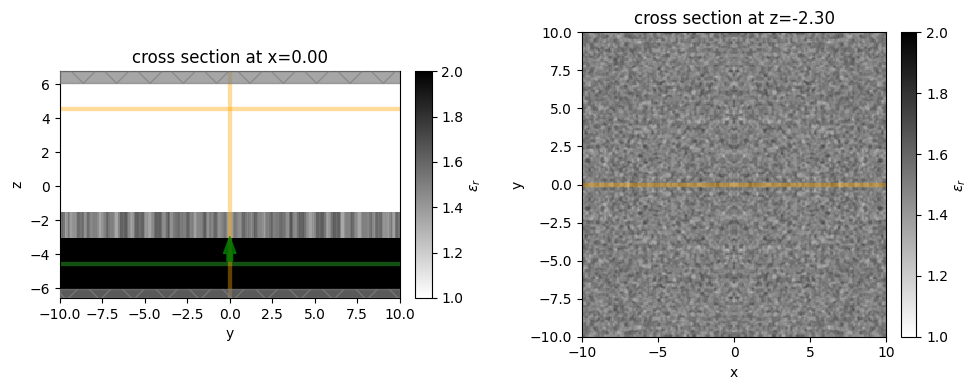

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1 = sim.plot_eps(x=0, ax=ax1)
ax2 = sim.plot_eps(z=z_center_slab, ax=ax2)
plt.show()

## Define Objective

We'll design this phase mask to give a transmitted intensity distribution of our choice.

### Define Target Intensity

In this case, we'll try to reproduce the Flexcompute logo, so let's make a function to generate that.

In [30]:
# !python3.11 -m pip install opencv-python
import cv2
import xarray as xr

logo_fname = "misc/logo.png"

def get_logo() -> np.ndarray:
    """Get the Flexcompute logo from file, load it into a numpy array, rescale it to (0, 1)."""
    im = cv2.imread(logo_fname, cv2.IMREAD_GRAYSCALE).astype(float)
    im -= np.min(im)
    im /= np.max(im)
    return im

def intensity_desired_fn_logo(xs:list, ys:list, rescale:float=0.5) -> np.ndarray:
    """Return the 'value' of the flexcompute logo as a function of (x,y) with some rescaling."""
    logo_values = get_logo()

    # some rotations to get the logo in the right orientation for the final intensity pattern
    logo_values = np.rot90(np.rot90(np.rot90(logo_values)))

    # re-interpolate the logo data at the supplied x,y points using xarray
    nx, ny = logo_values.shape
    xs_logo = np.linspace(rescale * min(xs), rescale * max(xs), nx)
    ys_logo = np.linspace(rescale * min(ys), rescale * max(ys), ny)    
    logo_dataarray = xr.DataArray(logo_values, coords=dict(x=xs_logo, y=ys_logo))
    logo_interp = logo_dataarray.interp(x=xs, y=ys)

    # handle any nans for out of bounds (replace with 0)
    return np.nan_to_num(logo_interp.values, nan=np.min(logo_interp))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 54.0 MB/s eta 0:00:00m eta 0:00:010:00:01


Let's test this function out by plotting our target intensity.

In [31]:
xs = ys = np.linspace(-length/2, length/2, nx)
intensity_desired = intensity_desired_fn_logo(xs, ys)

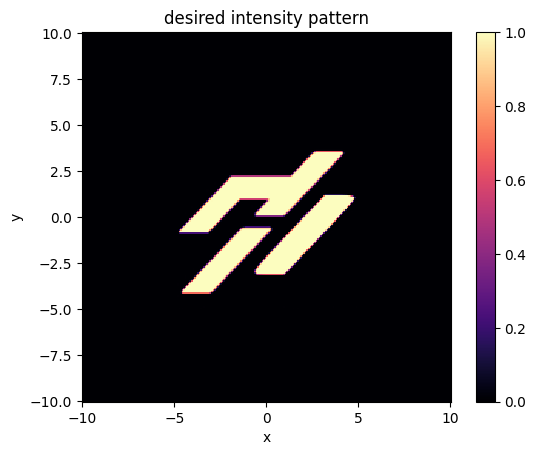

In [32]:
plt.pcolormesh(xs, ys, intensity_desired.T, cmap='magma')
plt.gca().set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('desired intensity pattern')
plt.colorbar()
plt.show()

### Compare Measurement to Target

Next we need a way to compare the measured intensity pattern to this target intensity pattern.

We'll come up with a figure of merit for the closeness of our objective.

First, let's run a simulation with an empty mask to figure out what the average intensity should be at the measurement plane (for normalization later).

> Note: Although Tidy3D normalizes field values by default, in this case doing a normalization run is useful as we're injecting from a substrate, which will affect the results. In the new caching feature of 2.6, these simulations will not use credits or much time when run after the first time.

In [36]:
import tidy3d.web as web

params_empty = np.zeros_like(params0)

sim_empty = make_sim(params_empty, beta=100)
sim_data_norm = web.run(sim_empty, task_name="normalization", verbose=True)
intensity_norm = sim_data_norm.get_intensity(mnt_out.name)
intensity_norm_mean = anp.mean(intensity_norm.values)

14:40:14 EDT Created task 'normalization' with task_id                          
             'fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=307125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=345283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\taskId]8;;\]8;id=307125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\=]8;;\]8;id=517697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\fdve]8;;\]8;id=307125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\-62c10ddb-f68]8;;\
             ]8;id=307125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\6-4dd6-8685-f814110fdfaa']8;;\.

Output()

14:40:15 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:40:19 EDT status = preprocess

14:40:20 EDT Maximum FlexCredit cost: 0.130. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

14:40:21 EDT running solver

Output()

14:40:29 EDT early shutoff detected at 4%, exiting.

             status = postprocess

Output()

14:40:30 EDT status = success

14:40:31 EDT View simulation result at                                          
             ]8;id=520603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=958935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\taskId]8;;\]8;id=520603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\=]8;;\]8;id=454364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\fdve]8;;\]8;id=520603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\-62c10ddb-f68]8;;\
             ]8;id=520603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-62c10ddb-f686-4dd6-8685-f814110fdfaa\6-4dd6-8685-f814110fdfaa']8;;\.

Output()

             loading simulation from simulation_data.hdf5

In [37]:
print(f"Average intensity of '{intensity_norm_mean:.2f}' (a.u.) measured without any device.")

Average intensity of '1.81' (a.u.) measured without any device.


Next let's write our loss function over the measured intensity data.

In [38]:
def get_intensities(sim_data: td.SimulationData) -> tuple[anp.ndarray, np.ndarray]:
    """Convenience function to grab the (unnormalized) intensity patterns from the data."""

    # first, grab the dataset storing the intensity values and coordinates
    mnt_out_name = mnt_out.name
    intensity_dataset = sim_data.get_intensity(mnt_out.name)
    xs = intensity_dataset.coords["x"]
    ys = intensity_dataset.coords["y"]

    # the "measured" values are just the raw data
    intensity_measured = anp.squeeze(intensity_dataset.values)

    # the "desired" or "target" values are the logo function evaluated at the data coords
    intensity_desired = intensity_desired_fn_logo(xs, ys)

    return intensity_measured, intensity_desired

# range within which to consider intensity as part of the objective function
# eg. if the measured intensity is above int_max, we just consider it at the target value of 1.0
intensity_range = int_min, int_max = (0.0, 1.0)

def intensity_diff_fn(sim_data: td.SimulationData) -> float:
    """Returns a measure for the amount of difference between desired and target intensity patterns."""

    intensity_measured, intensity_desired = get_intensities(sim_data)
    
    # normalize the measured intensity such that there's the same "power" in the signal as expected in the logo
    intensity_measured *= np.mean(intensity_desired) / intensity_norm_mean

    # apply the "capping" within intensity_range (optional)
    int_range_magnitude = abs(int_max - int_min)
    intensity_measured = anp.minimum(intensity_measured, int_max)
    intensity_measured = anp.maximum(intensity_measured, int_min)
    intensity_desired = int_range_magnitude * intensity_desired + int_min
    
    # take the elementwise difference
    difference = intensity_measured - intensity_desired
    
    # normalized by the 'worst case' (difference if measured was exact inverse of the target)
    difference_denominator = int_range_magnitude * np.ones_like(intensity_desired)
    
    # return the normalized norm of the difference
    return anp.linalg.norm(difference) / anp.linalg.norm(difference_denominator)


### Fabrication Constraints

If desired, we can add a fabrication constraint penalty to the figure of merit.

As in other notebooks, we can consider a simple penalty based on whether the structure changes upon dilation and erosion with a given distance.

In [39]:
from tidy3d.plugins.adjoint.utils.penalty import ErosionDilationPenalty

def penalty_fn(params, beta):
    processed_params = filter_project(params, beta=beta)
    
    penalty = ErosionDilationPenalty(pixel_size=dl_design_region, length_scale=radius)
    return penalty.evaluate(processed_params)

### Loss Function

Finally, we can throw all of this into a loss function to minimize. 

We will use a very small weight on our penalty function as it turns out to not be super important in this problem.

In [40]:

def loss_fn(params: anp.ndarray, beta: float) -> tuple[float, dict]:
    """Loss function for the design, the difference in intensity + the feature size penalty."""
    
    # construct and run the simulation
    sim = make_sim(params, beta=beta)
    sim_data = web.run(sim, task_name="phase_mask_example", verbose=False)
    
    # grab the respective and total losses
    return intensity_diff_fn(sim_data)

Before optimizing, let's test out our loss function to ensure we can run it and get the gradient of it with respect to the starting parameters.

In [41]:
# construct a funciton of `params` and `beta` that returns the loss value, gradient, and the aux_data
loss_fn_val_grad = autograd.value_and_grad(loss_fn)

# call this on our initial parmaeters
val, grad = loss_fn_val_grad(params0, beta=beta0)

TypeError: interp only works for a numeric type array. Given object.

In [ ]:
# penalty = aux_data["penalty"]
# intensity_diff = aux_data["intensity_diff"]

print(f"initial loss value = {val:.3f}")
# print(f" - penalty contribution = {penalty:.3f}")
# print(f" - intensity difference contribution = {intensity_diff:.3f}")
print(f"gradient shape = {grad.shape:}")
print(f"norm of gradient = {anp.linalg.norm(grad):.3e}")

Looks good! We get a reasonable loss value, our gradient has the expected shape, and it's non-zero (which can often indicate some issue concerning the flow of the gradient through the objective function.

> Note: we passed `has_aux=True`, which means that we tell `autograd` that the 2nd return value (`aux_data`) should be ignored in the gradient calculation. In other words, it tells `autograd` to only consider the gradient w.r.t. the first output (`total_loss`).

Let's also visualize the fields for another sanity check, which we can grab from the `aux_data`.

In [ ]:
sim_data = aux_data["sim_data"]
sim_data.plot_field(field_monitor_name="side", field_name="Ex", val="real")

plt.show()

## Optimize Device

Now we are finally ready to optimize our device.

As in the other tutorials, we use the implementation of "Adam Optimization" from `optax`.

In [ ]:
import optax

# hyperparameters
num_steps = 35
learning_rate = 0.75

# initialize adam optimizer with starting parameters
params = params0.copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
history = dict(loss=[], params=[], betas=[], penalty=[], intensity_diff=[], sim_data=[])

# gradually increase the binarization strength over iteration
beta_increment = 0.5
beta = beta0

for i in range(num_steps):
    print(f"step = ({i + 1} / {num_steps})")

    # compute gradient and current loss funciton value
    loss, gradient = loss_fn_val_grad(params, beta=beta)
    # penalty = aux_data["penalty"]
    # intensity_diff = aux_data["intensity_diff"]
    
    # save history
    history["loss"].append(loss)
    history["params"].append(params)
    history["betas"].append(beta)
    # history["penalty"].append(penalty)
    # history["intensity_diff"].append(intensity_diff)
    history["sim_data"].append(aux_data["sim_data"])
    
    # log some output
    print(f"\tloss = {loss:.3e}")
    # print(f"\t\tpenalty = {penalty:.3e}")
    # print(f"\t\tintensity difference = {intensity_diff:.3e}")
    print(f"\tbeta = {beta:.2f}")
    print(f"\t|gradient| = {np.linalg.norm(gradient):.3e}")    
    
    # compute and apply updates to the optimizer based on gradient (+1 sign to minimize loss_fn)
    updates, opt_state = optimizer.update(+gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap the parameters between their bounds
    params = anp.minimum(params, 1.0)
    params = anp.maximum(params, 0.0)
    
    # update the beta value
    beta += beta_increment


## Analyze Results

First, let's plot the objective function history.

In [ ]:
plt.plot(history["loss"], label="total loss")
# plt.plot(history["penalty"], linestyle="-.", label="penalty contribution")
# plt.plot(history["intensity_diff"], linestyle="--", label="intensity contribution")
plt.plot(np.zeros_like(history["loss"]), linestyle=":", color="k", label="no loss")

plt.xlabel("iteration number")
plt.ylabel("loss value")

plt.title("loss function over optimization")
plt.legend()
plt.show()

Next let's plot the final device pattern.

In [ ]:
# get the final parameters, construct the final simulation
params_final = history["params"][-1]
beta_final = history["betas"][-1]
sim_final = make_sim(params_final, beta=beta_final)

# convert to regular `td.Simulation`
sim_final.plot_eps(z=z_center_slab, monitor_alpha=0)

plt.show()

Let's run this simulation to see the final field patterns

In [ ]:
sim_data_final = web.run(sim_final, task_name='Inspect')

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for (ax, name) in zip(axes, ("output", "side")):
    sim_data_final.plot_field(field_monitor_name=name, field_name="E", val="abs^2", ax=ax)

Finally, we can create a nice figure combining everything.

In [ ]:
f, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(9, 10), tight_layout=True)

# target intensity
im = ax0.imshow(np.rot90(intensity_desired), cmap="magma")
ax0.set_aspect("equal")
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_title('target intensity (normalized)')
plt.colorbar(im, ax=ax0)

# optimization progress
ax1.plot(history["loss"], label="total loss")
# ax1.plot(history["penalty"], linestyle="-.", label="penalty contribution")
# ax1.plot(history["intensity_diff"], linestyle="--", label="intensity contribution")
ax1.plot(np.zeros_like(history["loss"]), linestyle=":", color="k", label="no loss")
ax1.set_xlabel("iteration number")
ax1.set_ylabel("loss value")
ax1.set_title("loss function over optimization")
ax1.legend()

# ax1.plot(history["loss"])
# ax1.set_xlabel("iterations")
# ax1.set_ylabel("loss function")
# ax1.set_title('optimization progress')

# final device (top and sides)
sim_final.plot_eps(z=z_center_slab, ax=ax2)
ax2.set_title("final design")
sim_final.plot_eps(x=0, ax=ax3)
ax3.set_title("cross section")

# final fields
vmin = None
vmax = None
for (ax, name) in zip((ax4, ax5), ("output", "side")):
    sim_data_final.plot_field(field_monitor_name=name, field_name="E", val="abs^2", vmin=vmin, vmax=vmax, ax=ax)

# plt.savefig('phase_mask.png', dpi=300)
plt.show()